# **Tourism Intelligence**

## **Data Ingestion & Preparation**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif

In [2]:
file_path = "SL Tourism Data.xlsx"

try:
    df_arrivals  = pd.read_excel(file_path, sheet_name="Arrivals")
    df_purpose   = pd.read_excel(file_path, sheet_name="Purpose")
    df_duration  = pd.read_excel(file_path, sheet_name="Duration of Stay")
    df_age       = pd.read_excel(file_path, sheet_name="Age")
    df_occupancy = pd.read_excel(file_path, sheet_name="Occupancy")
    print("All sheets loaded successfully!")

except Exception as error:
    print("Error loading Excel file or sheets")
    print(error)

All sheets loaded successfully!


In [3]:
#Convert Year to Integers
df_arrivals["Year"] = df_arrivals["Year"].astype(int)


month_columns = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

#Unpivot Arrivals Data (Wide format to Long format)
df_arrivals_long = df_arrivals.melt(
    id_vars=["Year", "Region", "Country"],
    value_vars=month_columns,
    var_name="Month",
    value_name="Arrivals")

df_arrivals_long["Arrivals"] = df_arrivals_long["Arrivals"].astype(int)



#Convert Month Names to Numbers
month_map = {"January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12}

df_arrivals_long["Month_Num"] = df_arrivals_long["Month"].map(month_map)


#Create Date Column
df_arrivals_long["Date"] = pd.to_datetime(
    dict(year=df_arrivals_long["Year"],
        month=df_arrivals_long["Month_Num"],
        day=1))


#Sort Data
df_arrivals_long = df_arrivals_long.sort_values(by=["Country", "Date"])

print("Arrivals data cleaned and structured")
df_arrivals_long.head()

Arrivals data cleaned and structured


,Year,Region,Country,Month,Arrivals,Month_Num,Date
34,2011,Australasia,Australia,January,3588,1,2011-01-01
425,2011,Australasia,Australia,February,2223,2,2011-02-01
816,2011,Australasia,Australia,March,3017,3,2011-03-01
1207,2011,Australasia,Australia,April,3341,4,2011-04-01
1598,2011,Australasia,Australia,May,1764,5,2011-05-01


## **Feature Engineering**

In [4]:
#Extract Quarter from Date (Q1–Q4)
df_arrivals_long["Quarter"] = df_arrivals_long["Date"].dt.quarter

In [5]:
#3 month Moving Average of Arrivals
df_arrivals_long["MA_3"] = (
    df_arrivals_long
    .groupby("Country")["Arrivals"]
    .transform(lambda x: x.rolling(window=3).mean()))

In [6]:
#Year-over-Year growth rate (percentage)
df_arrivals_long["YoY_Growth"] = (
    df_arrivals_long
    .groupby("Country")["Arrivals"]
    .pct_change(periods=12))

In [7]:
df_arrivals_long

,Year,Region,Country,Month,Arrivals,Month_Num,Date,Quarter,MA_3,YoY_Growth
34,2011,Australasia,Australia,January,3588,1,2011-01-01,1,NaN,NaN
425,2011,Australasia,Australia,February,2223,2,2011-02-01,1,NaN,NaN
816,2011,Australasia,Australia,March,3017,3,2011-03-01,1,2942.666667,NaN
1207,2011,Australasia,Australia,April,3341,4,2011-04-01,2,2860.333333,NaN
1598,2011,Australasia,Australia,May,1764,5,2011-05-01,2,2707.333333,NaN
...,...,...,...,...,...,...,...,...,...,...
3099,2019,Eastern Europe,Ukraine,August,985,8,2019-08-01,3,782.666667,-0.348976
3490,2019,Eastern Europe,Ukraine,September,1321,9,2019-09-01,3,1024.666667,-0.423647
3881,2019,Eastern Europe,Ukraine,October,2655,10,2019-10-01,4,1653.666667,-0.011909
4272,2019,Eastern Europe,Ukraine,November,4770,11,2019-11-01,4,2915.333333,0.383010


In [8]:
df_arrivals_long.describe()

,Year,Arrivals,Month_Num,Date,Quarter,MA_3,YoY_Growth
count,4692.000000,4692.000000,4692.00000,4692,4692.000000,4596.000000,4116.000000
mean,2015.191816,3170.879369,6.50000,2015-08-25 20:35:36.061381120,2.500000,3171.226501,0.200999
min,2011.000000,4.000000,1.00000,2011-01-01 00:00:00,1.000000,8.666667,-0.926087
25%,2013.000000,656.000000,3.75000,2013-06-01 00:00:00,1.750000,728.750000,-0.096454
50%,2015.000000,1375.000000,6.50000,2015-10-01 00:00:00,2.500000,1423.333333,0.102195
75%,2017.000000,3135.000000,9.25000,2017-12-01 00:00:00,3.250000,3128.916667,0.300825
max,2019.000000,48442.000000,12.00000,2019-12-01 00:00:00,4.000000,41661.000000,10.894737
std,2.552345,5208.697864,3.45242,NaN,1.118153,5041.462832,0.726499


Features for Clustering

In [9]:
#Average Growth
df_annual = df_arrivals_long.groupby(['Country', 'Year'])['Arrivals'].sum().reset_index()
df_annual['Prev'] = df_annual.groupby('Country')['Arrivals'].shift(1)
df_annual['Avg_Growth'] = (df_annual['Arrivals'] - df_annual['Prev']) / df_annual['Prev']
df_annual = df_annual.replace([np.inf, -np.inf], np.nan).fillna(0)
Avg_Growth = df_annual.groupby('Country')['Avg_Growth'].mean()

In [10]:
#Seasonality
Seasonality = df_arrivals_long.groupby('Country')['Arrivals'].std() / df_arrivals_long.groupby('Country')['Arrivals'].mean()

In [11]:
#Average Duration
df_duration['Val'] = pd.to_numeric(df_duration['Average Duration of Stay'], errors='coerce')
others_lookup = df_duration[df_duration['Country'].str.contains('Others -')].set_index(['Year', 'Region'])['Val'].to_dict()

def fill_dur(row):
    if pd.notna(row['Val']): return row['Val']
    return others_lookup.get((row['Year'], row['Region']), np.nan)

df_duration['Avg_Duration'] = df_duration.apply(fill_dur, axis=1)
Avg_Duration = df_duration.groupby('Country')['Avg_Duration'].mean()

In [12]:
#Purpose
pur_cols = [c for c in df_purpose.columns if c not in ['Year', 'Region', 'Country']]

for c in pur_cols: df_purpose[c] = pd.to_numeric(df_purpose[c], errors='coerce').fillna(0)
df_purpose['Total'] = df_purpose[pur_cols].sum(axis=1)
df_purpose = df_purpose[df_purpose['Total'] > 0]

#We keep Leisure. Low Leisure implies High Business.
df_purpose['Leisure_Ratio'] = (df_purpose['Pleasure'] + df_purpose['Visiting Friends & Relations']) / df_purpose['Total']
df_purpose['Business_Ratio'] = (df_purpose['Convention & Meetings'] + df_purpose['Private & Official Business']) / df_purpose['Total']
Purpose = df_purpose.groupby('Country')[['Leisure_Ratio','Business_Ratio']].mean()

In [13]:
#AGE
age_cols = [c for c in df_age.columns if c not in ['Year', 'Region', 'Country']]

for c in age_cols: df_age[c] = pd.to_numeric(df_age[c], errors='coerce').fillna(0)
df_age['Total'] = df_age[age_cols].sum(axis=1)
df_age = df_age[df_age['Total'] > 0]

#We keep Young AND Silver.
df_age['Young_Ratio'] = df_age['20-29'] / df_age['Total']
df_age['Silver_Ratio'] = df_age['60 & above'] / df_age['Total']
Age = df_age.groupby('Country')[['Young_Ratio', 'Silver_Ratio']].mean()

In [14]:
#Merge
df_master = pd.concat([Seasonality, Avg_Growth, Avg_Duration, Purpose, Age], axis=1)
df_master.columns = ['Seasonality', 'Avg_Growth', 'Avg_Duration', 'Leisure_Ratio','Business_Ratio', 'Young_Ratio', 'Silver_Ratio']

In [15]:
df_master.isna().sum()

,0
Seasonality,0
Avg_Growth,0
Avg_Duration,10
Leisure_Ratio,0
Business_Ratio,0
Young_Ratio,0
Silver_Ratio,0


In [16]:
df_master[df_master['Avg_Duration'].isna()]

,Seasonality,Avg_Growth,Avg_Duration,Leisure_Ratio,Business_Ratio,Young_Ratio,Silver_Ratio
Country,,,,,,,
Czech Republic,0.691379,0.163384,NaN,0.972560,0.007067,0.212235,0.113930
Israel,0.541452,0.104674,NaN,0.961348,0.018781,0.326062,0.119107
Kuwait,0.666941,-0.125444,NaN,0.924036,0.026983,0.195820,0.090221
Oman,1.008101,-0.025624,NaN,0.957819,0.022802,0.284949,0.038023
Others - East Asia,0.468102,0.086703,NaN,0.870032,0.078604,0.173308,0.155644
Others - South Asia,0.564642,0.621969,NaN,0.758432,0.154568,0.222805,0.070234
Poland,0.686071,0.145571,NaN,0.948702,0.026316,0.160287,0.105839
Saudi Arabia,0.886265,-0.008922,NaN,0.966325,0.007767,0.252937,0.037946
South Africa,0.776772,0.165324,NaN,0.880981,0.053585,0.169309,0.134594


In [17]:
#Grab unique Country-Region pairs from long df
region_map = df_arrivals_long[['Country', 'Region']].set_index('Country')['Region'].to_dict()

#Look up the Region for every country in df_master
df_master['Region'] = df_master.index.map(region_map)

#Check if any didn't get mapped (Safety check)
print(f"Countries without a region: {df_master['Region'].isna().sum()}")

#Groups by Region; Calculates Mean Duration for that Region (ignoring NaNs); Fills ONLY the missing values in 'Avg_Duration' with that specific regional mean
df_master['Avg_Duration'] = df_master['Avg_Duration'].fillna(df_master.groupby('Region')['Avg_Duration'].transform('mean'))

df_master.drop(columns=['Region'], inplace=True)

Countries without a region: 0


In [18]:
df_master[df_master['Avg_Duration'].isna()]

,Seasonality,Avg_Growth,Avg_Duration,Leisure_Ratio,Business_Ratio,Young_Ratio,Silver_Ratio
Country,,,,,,,


In [19]:
df_master.describe()

,Seasonality,Avg_Growth,Avg_Duration,Leisure_Ratio,Business_Ratio,Young_Ratio,Silver_Ratio
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.608110,0.128938,10.162797,0.898341,0.058669,0.189616,0.129052
std,0.197470,0.145423,2.479592,0.065423,0.041176,0.047431,0.053670
min,0.259154,-0.125444,6.188889,0.678207,0.007067,0.116079,0.033175
25%,0.461215,0.061940,7.919444,0.878662,0.029602,0.160342,0.090055
50%,0.608518,0.103244,9.435833,0.919130,0.044845,0.186746,0.127333
75%,0.709660,0.163869,12.288889,0.944343,0.080069,0.205257,0.178767
max,1.048258,0.621969,14.588889,0.972560,0.203278,0.326062,0.233765


## **Exploratory Data Visualisation**

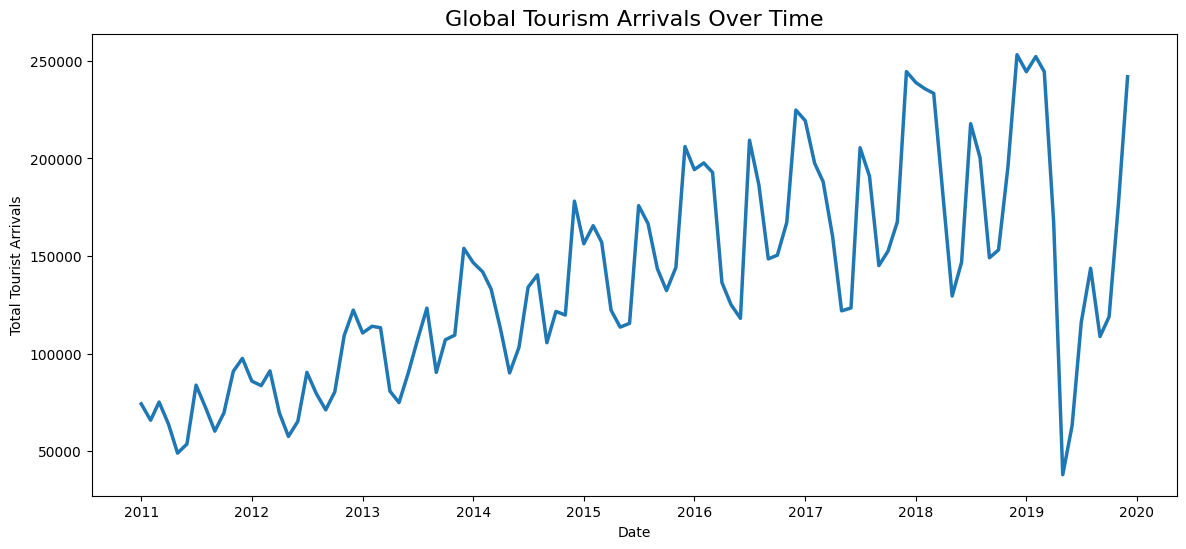

In [20]:
#Aggregate total arrivals across all countries for each month
global_trend = (
    df_arrivals_long
    .groupby("Date", as_index=False)["Arrivals"]
    .sum())

plt.figure(figsize=(14, 6))

sns.lineplot(
    data=global_trend,
    x="Date",
    y="Arrivals",
    linewidth=2.5)

plt.title("Global Tourism Arrivals Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Tourist Arrivals")

plt.show()

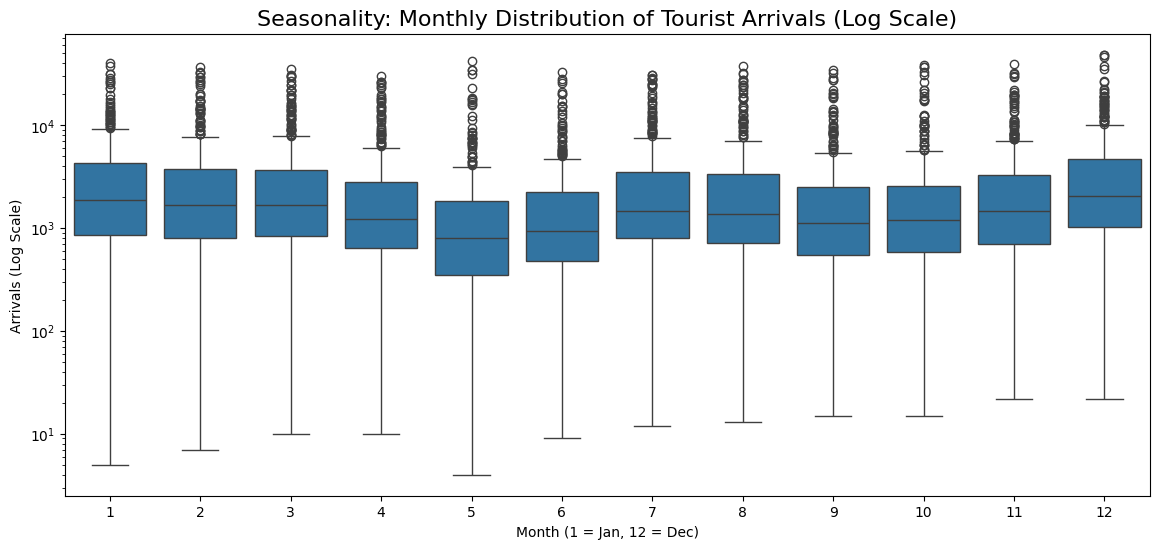

In [21]:
plt.figure(figsize=(14, 6))

sns.boxplot(
    data=df_arrivals_long,
    x="Month_Num",
    y="Arrivals")

#Log scale to handle large differences in Arrivals
plt.yscale("log")

plt.title("Seasonality: Monthly Distribution of Tourist Arrivals (Log Scale)", fontsize=16)
plt.xlabel("Month (1 = Jan, 12 = Dec)")
plt.ylabel("Arrivals (Log Scale)")

plt.show()

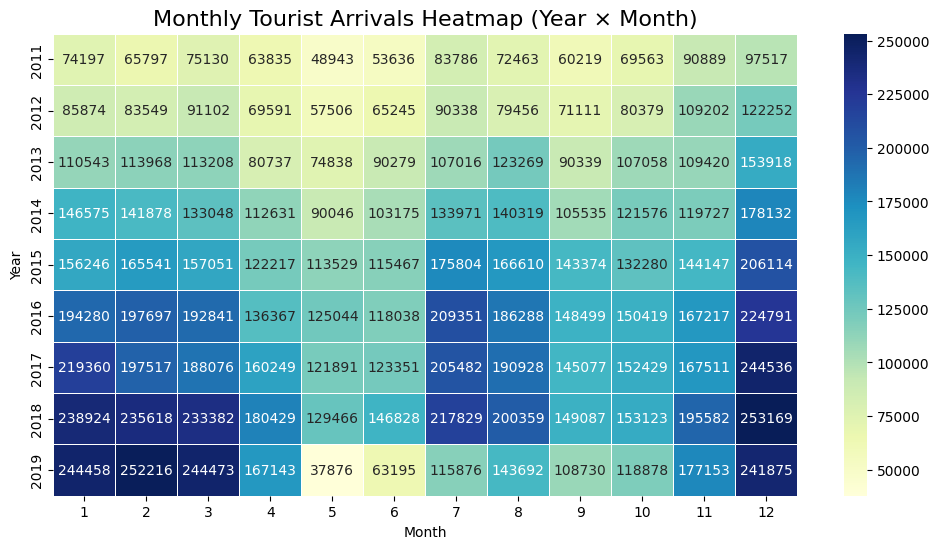

In [22]:
#Extract Year & Month from Date
df_arrivals_long["Year"] = df_arrivals_long["Date"].dt.year
df_arrivals_long["Month"] = df_arrivals_long["Date"].dt.month

#Aggregate: Total arrivals per Year × Month
year_month = (
    df_arrivals_long
    .groupby(["Year", "Month"], as_index=False)["Arrivals"]
    .sum()
    .pivot(index="Year", columns="Month", values="Arrivals"))

plt.figure(figsize=(12, 6))
sns.heatmap(
    year_month,
    cmap="YlGnBu",
    annot=True,
    fmt=".0f",
    linewidths=0.5)

plt.title("Monthly Tourist Arrivals Heatmap (Year × Month)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

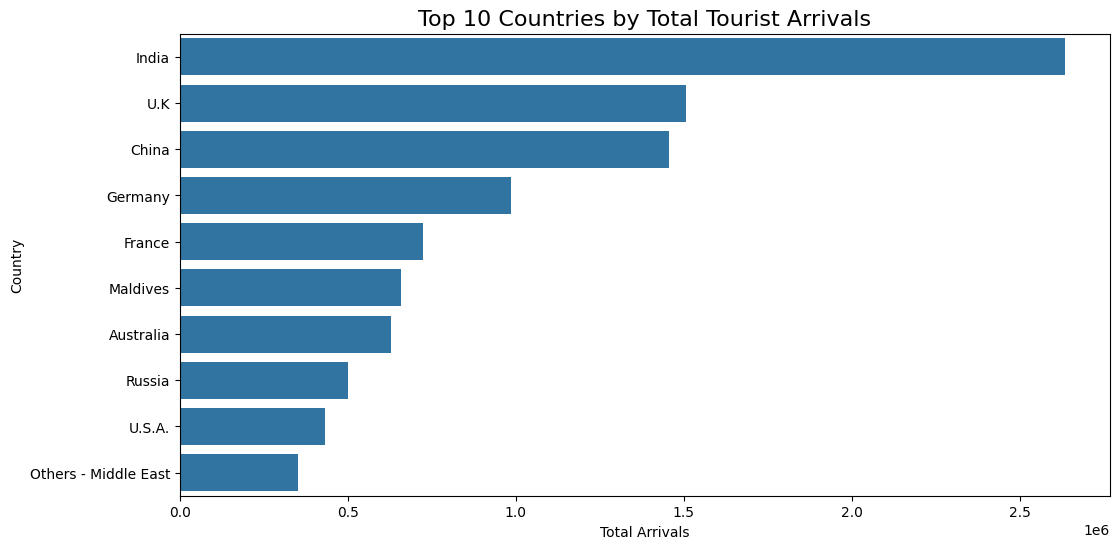

In [23]:
#Aggregate total arrivals by country
top_10_countries = (
    df_arrivals_long
    .groupby("Country")["Arrivals"]
    .sum()
    .sort_values(ascending=False)
    .head(10))

plt.figure(figsize=(12, 6))

sns.barplot(
    x=top_10_countries.values,
    y=top_10_countries.index)

plt.title("Top 10 Countries by Total Tourist Arrivals", fontsize=16)
plt.xlabel("Total Arrivals")
plt.ylabel("Country")

plt.show()

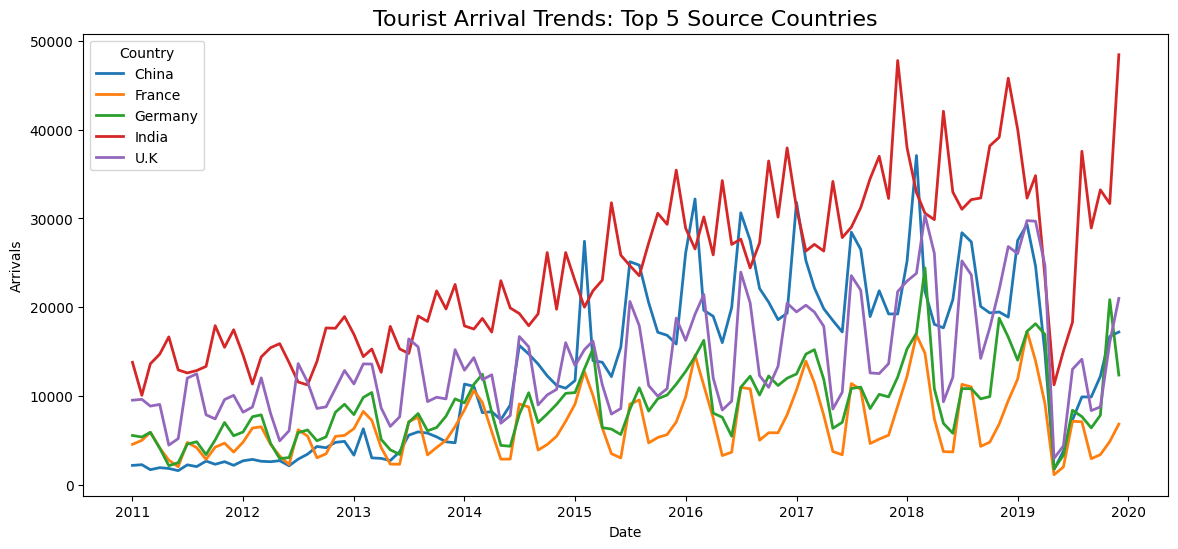

In [24]:
#Top 5 countries by total arrivals
top_5_countries = top_10_countries.head(5).index.tolist()

#Filter data for only these countries
df_top_5 = df_arrivals_long[
    df_arrivals_long["Country"].isin(top_5_countries)]

plt.figure(figsize=(14, 6))

sns.lineplot(
    data=df_top_5,
    x="Date",
    y="Arrivals",
    hue="Country",
    linewidth=2)

plt.title("Tourist Arrival Trends: Top 5 Source Countries", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Arrivals")

plt.show()

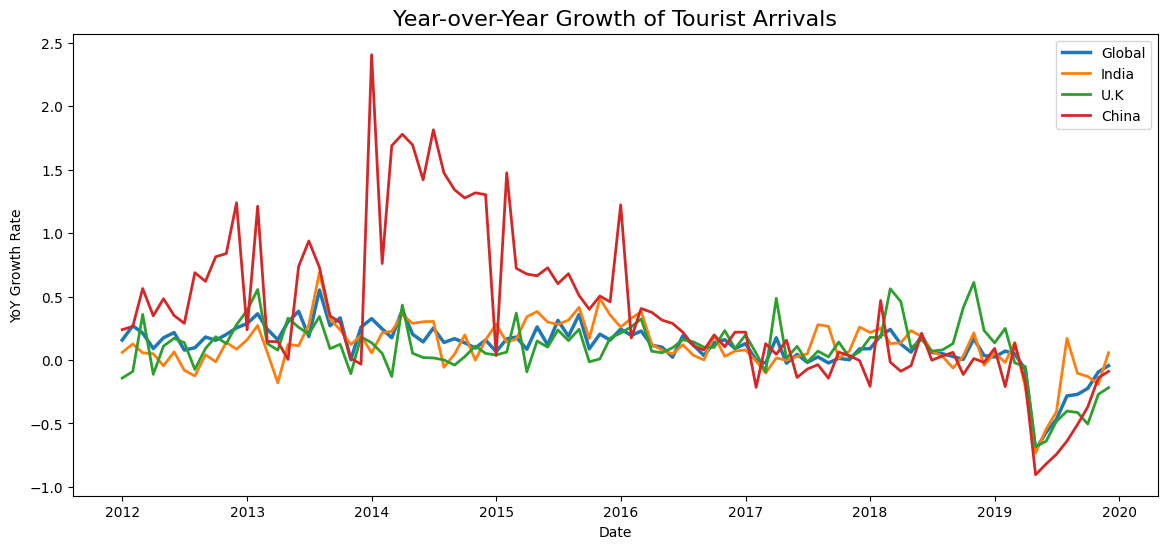

In [25]:
plt.figure(figsize=(14, 6))

#Global YoY Growth
global_yoy = (
    df_arrivals_long
    .groupby("Date")["Arrivals"]
    .sum()
    .pct_change(periods=12))

sns.lineplot(x=global_yoy.index, y=global_yoy.values, linewidth=2.5, label="Global")

#YoY Growth for Top 3 Countries
for country in top_5_countries[:3]:
    country_yoy = (
        df_arrivals_long[df_arrivals_long["Country"] == country]
        .set_index("Date")["Arrivals"]
        .pct_change(periods=12)
    )
    sns.lineplot(x=country_yoy.index, y=country_yoy.values, linewidth=2, label=country)

plt.title("Year-over-Year Growth of Tourist Arrivals", fontsize=16)
plt.ylabel("YoY Growth Rate")
plt.xlabel("Date")
plt.legend()
plt.show()

<Figure size 1400x600 with 0 Axes>

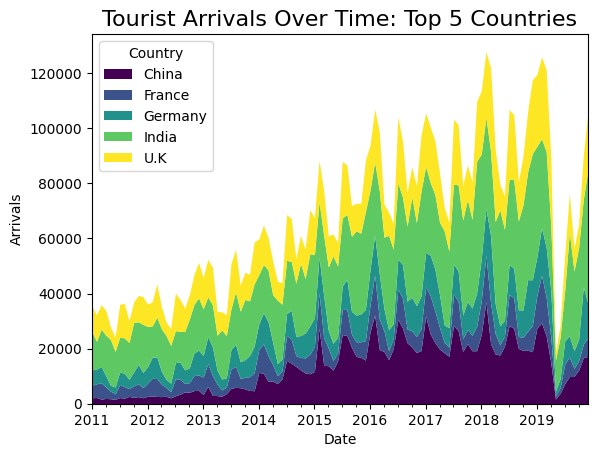

In [26]:
#Filter top 5 countries
top_5_names = top_10_countries.head(5).index.tolist()
df_top_5 = df_arrivals_long[df_arrivals_long["Country"].isin(top_5_names)]


#Pivot for stacked plot
area_data = df_top_5.pivot(index="Date", columns="Country", values="Arrivals").fillna(0)

plt.figure(figsize=(14, 6))
area_data.plot.area(colormap="viridis", linewidth=0)
plt.title("Tourist Arrivals Over Time: Top 5 Countries", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Arrivals")
plt.legend(title="Country")
plt.show()

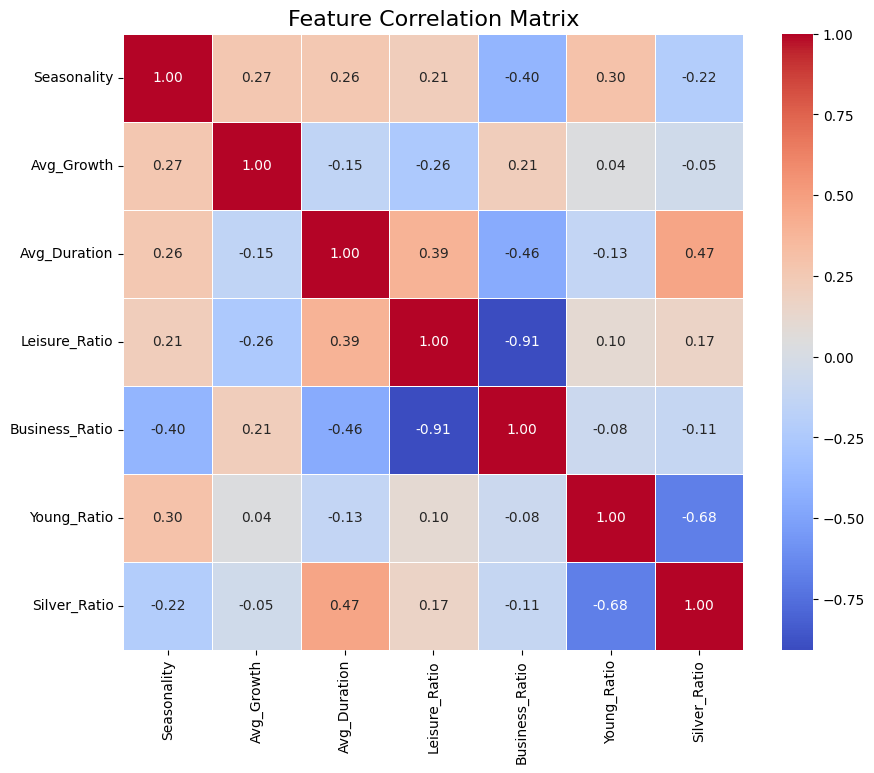

In [27]:
#Correlation Matrix
corr_matrix = df_master.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5)

plt.title("Feature Correlation Matrix", fontsize=16)

plt.show()

##**Clustering**

### Preparation

In [28]:
df_master = df_master.drop(columns=['Business_Ratio'])

In [29]:
df_cluster = df_master.copy()
df_cluster

,Seasonality,Avg_Growth,Avg_Duration,Leisure_Ratio,Young_Ratio,Silver_Ratio
Country,,,,,,
Australia,0.511784,0.101815,12.166667,0.939152,0.148661,0.204523
Austria,0.655939,0.113797,14.244444,0.911461,0.168811,0.189922
Bangladesh,0.333145,-0.003023,6.228571,0.895526,0.190027,0.065255
Belgium,0.555661,0.055244,12.055556,0.945742,0.208768,0.127862
Canada,0.385099,0.081523,14.588889,0.942934,0.124994,0.189846
China,0.689634,0.323392,8.628889,0.916311,0.213142,0.114579
Czech Republic,0.691379,0.163384,10.010926,0.972560,0.212235,0.113930
Denmark,0.774770,0.118984,14.388889,0.918188,0.198621,0.182529
Finland,1.017964,0.238371,13.200000,0.940380,0.176225,0.178733


Inter Quartile Range

In [30]:
#Cap values outside IQR
df_iqr = df_cluster.copy()

#Select numeric columns only
num_cols = df_iqr.select_dtypes(include='number').columns

for col in num_cols:
    Q1 = df_iqr[col].quantile(0.25)
    Q3 = df_iqr[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_iqr[col] = df_iqr[col].clip(lower_bound, upper_bound)

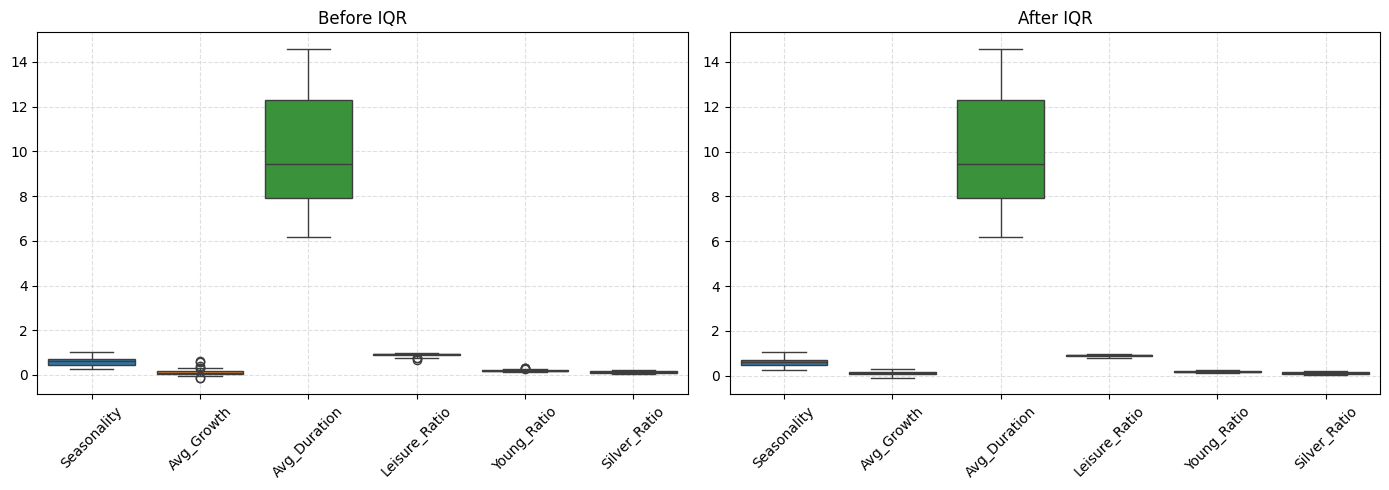

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df_cluster.select_dtypes(include='number'), ax=axes[0])
axes[0].set_title('Before IQR')

sns.boxplot(data=df_iqr.select_dtypes(include='number'), ax=axes[1])
axes[1].set_title('After IQR')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [32]:
#Define the specific columns you want to check
cols_to_check = ['Avg_Growth', 'Leisure_Ratio', 'Young_Ratio']

#Create a comparison dictionary
comparison_data = []

for col in cols_to_check:
    comparison_data.append({
        'Feature': col,
        'Original Min': df_cluster[col].min(),
        'Capped Min': df_iqr[col].min(),
        'Min Reduced By' : df_cluster[col].min() - df_iqr[col].min(),
        'Original Max': df_cluster[col].max(),
        'Capped Max': df_iqr[col].max(),
        'Max Reduced By': df_cluster[col].max() - df_iqr[col].max()})

#Convert to DataFrame for table view
import pandas as pd
comparison_df = pd.DataFrame(comparison_data)

#Display table
comparison_df.round(4)

,Feature,Original Min,Capped Min,Min Reduced By,Original Max,Capped Max,Max Reduced By
0,Avg_Growth,-0.1254,-0.0910,-0.0345,0.6220,0.3168,0.3052
1,Leisure_Ratio,0.6782,0.7801,-0.1019,0.9726,0.9726,0.0000
2,Young_Ratio,0.1161,0.1161,0.0000,0.3261,0.2726,0.0534


Scaling

In [33]:
#Standard scaler features so all variables contribute equally
scaler = StandardScaler()
X_std = scaler.fit_transform(df_cluster)

#KMeans
kmeans_std = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_std = kmeans_std.fit_predict(X_std)

df_std = df_cluster.copy()
df_std['Cluster'] = labels_std

df_cluster.head()

,Seasonality,Avg_Growth,Avg_Duration,Leisure_Ratio,Young_Ratio,Silver_Ratio
Country,,,,,,
Australia,0.511784,0.101815,12.166667,0.939152,0.148661,0.204523
Austria,0.655939,0.113797,14.244444,0.911461,0.168811,0.189922
Bangladesh,0.333145,-0.003023,6.228571,0.895526,0.190027,0.065255
Belgium,0.555661,0.055244,12.055556,0.945742,0.208768,0.127862
Canada,0.385099,0.081523,14.588889,0.942934,0.124994,0.189846


In [34]:
#Robust Scaler
scaler_rob = RobustScaler()
X_rob = scaler_rob.fit_transform(df_cluster)

#KMeans
kmeans_rob = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_rob = kmeans_rob.fit_predict(X_rob)

df_rob = df_cluster.copy()
df_rob['Cluster'] = labels_rob

In [35]:
comparison = pd.DataFrame({
    'StandardScaler': df_std['Cluster'],
    'RobustScaler': df_rob['Cluster']})

pd.crosstab(comparison['StandardScaler'], comparison['RobustScaler'])

RobustScaler,0,1,2,3,4
StandardScaler,,,,,
0,0,4,0,16,0
1,7,0,0,0,0
2,4,0,1,0,0
3,0,4,0,0,2
4,0,3,7,0,0


In [36]:
print("StandardScaler Profiles")
print(df_std.groupby('Cluster').mean())

print("\nRobustScaler Profiles")
print(df_rob.groupby('Cluster').mean())

StandardScaler Profiles
         Seasonality  Avg_Growth  Avg_Duration  Leisure_Ratio  Young_Ratio  \
Cluster                                                                      
0           0.637907    0.126703     12.514546       0.932072     0.171721   
1           0.371374    0.062454      7.447540       0.869549     0.135664   
2           0.418594    0.012258      8.600825       0.797793     0.212383   
3           0.714736    0.428504      7.976005       0.827009     0.199264   
4           0.745013    0.058547      9.453037       0.944107     0.245999   

         Silver_Ratio  
Cluster                
0            0.164680  
1            0.170225  
2            0.081575  
3            0.103159  
4            0.068248  

RobustScaler Profiles
         Seasonality  Avg_Growth  Avg_Duration  Leisure_Ratio  Young_Ratio  \
Cluster                                                                      
0           0.403040    0.042454      7.936890       0.846232     0.154421   
1   

### Finding the optimal number of clusters

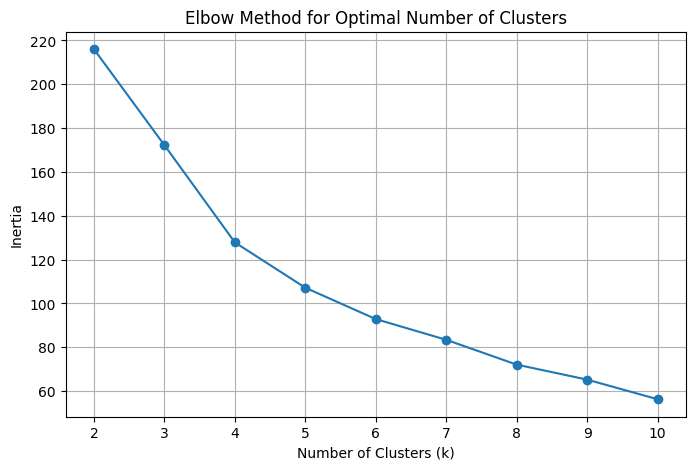

In [37]:
#Elbow Plot
inertia = []
K_range = range(2, 11)

for k in K_range:
    model = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10)
    model.fit(X_std)
    inertia.append(model.inertia_)

#Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

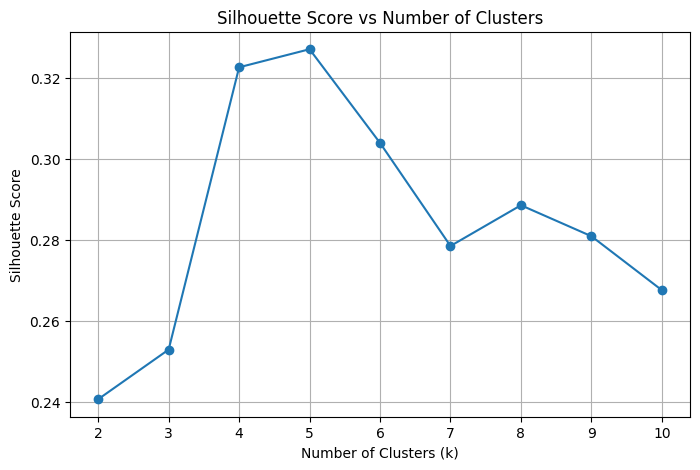

In [38]:
#Silhouette Score
from sklearn.metrics import silhouette_score

silhouette_scores = []

K_range = range(2, 11)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_std)
    score = silhouette_score(X_std, labels)
    silhouette_scores.append(score)

#Plot
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

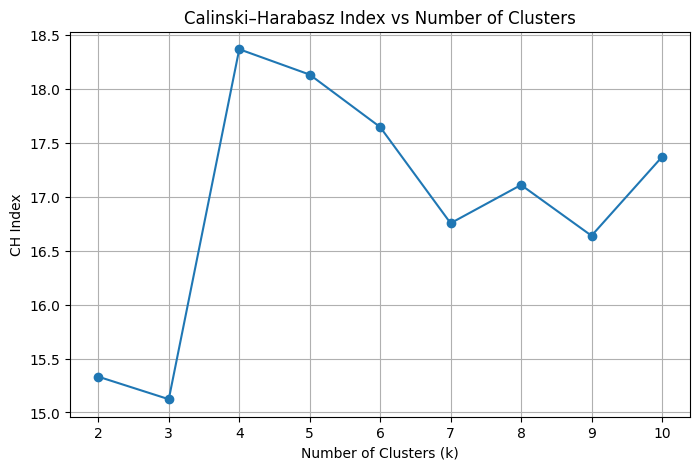

In [39]:
#Calinski Harabasz Score
from sklearn.metrics import calinski_harabasz_score

ch_scores = []

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_std)
    ch_scores.append(calinski_harabasz_score(X_std, labels))

#Plot
plt.figure(figsize=(8, 5))
plt.plot(K_range, ch_scores, marker='o')
plt.title('Calinski–Harabasz Index vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('CH Index')
plt.grid(True)
plt.show()

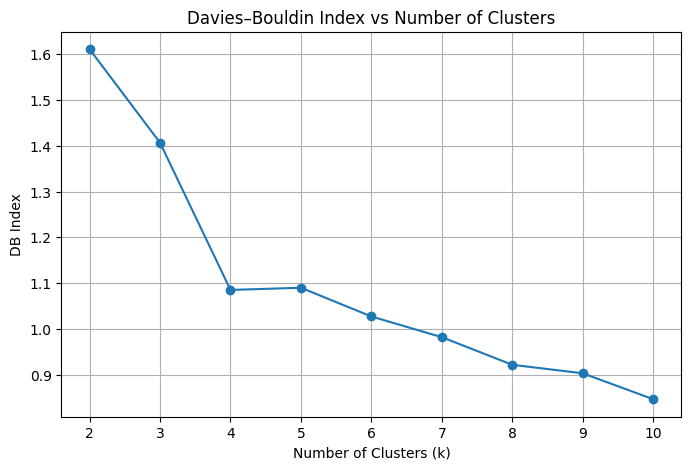

In [40]:
#Davies Bouldin Score
from sklearn.metrics import davies_bouldin_score

db_scores = []

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_std)
    db_scores.append(davies_bouldin_score(X_std, labels))

#Plot
plt.figure(figsize=(8, 5))
plt.plot(K_range, db_scores, marker='o')
plt.title('Davies–Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')
plt.grid(True)
plt.show()

In [41]:
#Comparison
k_eval = pd.DataFrame({
    'k': list(K_range),
    'Inertia': inertia,
    'Silhouette': silhouette_scores,
    'Calinski_Harabasz': ch_scores,
    'Davies_Bouldin': db_scores})

k_eval

,k,Inertia,Silhouette,Calinski_Harabasz,Davies_Bouldin
0,2,216.005528,0.240642,15.331764,1.610591
1,3,172.235715,0.252906,15.122859,1.406506
2,4,127.862448,0.322657,18.368834,1.085213
3,5,107.189676,0.327120,18.133379,1.090004
4,6,92.878718,0.303966,17.646871,1.027300
5,7,83.430492,0.278504,16.755165,0.982102
6,8,72.103365,0.288572,17.110090,0.921888
7,9,65.259424,0.280921,16.639134,0.903302
8,10,56.317347,0.267591,17.369704,0.846733


### K Means Clustering

In [42]:
K = 5

kmeans = KMeans(
    n_clusters=K,
    random_state=42,
    n_init=10)

#Create Clusters on Normalised Data
clusters = kmeans.fit_predict(X_std)

#Cluster Labels
df_clustered = df_cluster.copy()
df_clustered['Cluster'] = clusters

print("Clustering completed.")

Clustering completed.


In [43]:
df_clustered

,Seasonality,Avg_Growth,Avg_Duration,Leisure_Ratio,Young_Ratio,Silver_Ratio,Cluster
Country,,,,,,,
Australia,0.511784,0.101815,12.166667,0.939152,0.148661,0.204523,0
Austria,0.655939,0.113797,14.244444,0.911461,0.168811,0.189922,0
Bangladesh,0.333145,-0.003023,6.228571,0.895526,0.190027,0.065255,2
Belgium,0.555661,0.055244,12.055556,0.945742,0.208768,0.127862,0
Canada,0.385099,0.081523,14.588889,0.942934,0.124994,0.189846,0
China,0.689634,0.323392,8.628889,0.916311,0.213142,0.114579,3
Czech Republic,0.691379,0.163384,10.010926,0.972560,0.212235,0.113930,4
Denmark,0.774770,0.118984,14.388889,0.918188,0.198621,0.182529,0
Finland,1.017964,0.238371,13.200000,0.940380,0.176225,0.178733,0


In [44]:
#Average feature profile per cluster
cluster_profile = df_clustered.groupby('Cluster').mean()

In [45]:
cluster_profile

,Seasonality,Avg_Growth,Avg_Duration,Leisure_Ratio,Young_Ratio,Silver_Ratio
Cluster,,,,,,
0,0.637907,0.126703,12.514546,0.932072,0.171721,0.164680
1,0.371374,0.062454,7.447540,0.869549,0.135664,0.170225
2,0.418594,0.012258,8.600825,0.797793,0.212383,0.081575
3,0.714736,0.428504,7.976005,0.827009,0.199264,0.103159
4,0.745013,0.058547,9.453037,0.944107,0.245999,0.068248


In [46]:
#Z-score normalization (global baseline)

global_mean = df_clustered.drop(columns='Cluster').mean()
global_std = df_clustered.drop(columns='Cluster').std()

norm_profile = (cluster_profile - global_mean) / global_std

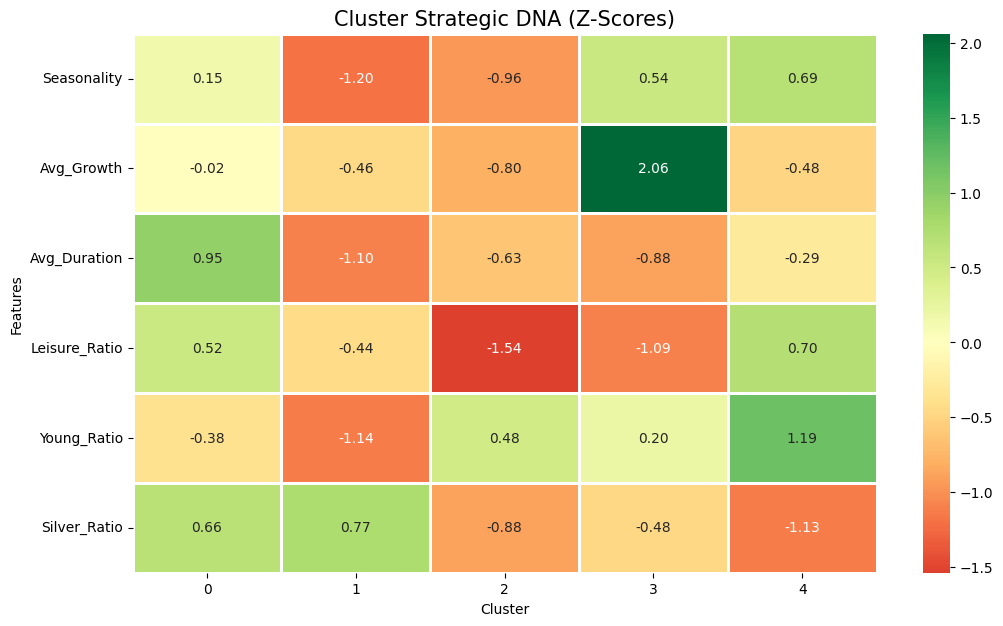


Cluster 0 (20 countries):
Australia, Austria, Belgium, Canada, Denmark, Finland, France, Germany, Italy, Netherlands, New Zealand, Norway, Others - Western Europe, Poland, South Africa, Spain, Sweden, Switzerland, U.K, U.S.A.

Cluster 1 (7 countries):
India, Japan, Malaysia, Others - East Asia, Singapore, South Korea, Thailand

Cluster 2 (5 countries):
Bangladesh, Maldives, Others - Asia, Others - Australasia, Pakistan

Cluster 3 (6 countries):
China, Indonesia, Others - Africa, Others - Latin America & The Caribbean, Others - South Asia, Philippines

Cluster 4 (10 countries):
Czech Republic, Israel, Kuwait, Oman, Others - Eastern Europe, Others - Middle East, Russia, Saudi Arabia, UAE, Ukraine


In [47]:
#Heatmap (Strategic DNA)

plt.figure(figsize=(12, 7))
sns.heatmap(
    norm_profile.T,
    annot=True,
    cmap='RdYlGn',
    center=0,
    linewidths=0.8,
    fmt='.2f')

plt.title('Cluster Strategic DNA (Z-Scores)', fontsize=15)
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.show()

#Country roll call per cluster

for cluster_id in sorted(df_clustered['Cluster'].unique()):
    countries = df_clustered[df_clustered['Cluster'] == cluster_id].index.tolist()
    print(f"\nCluster {cluster_id} ({len(countries)} countries):")
    print(', '.join(countries))

### Principal Component Analysis - Visualise Clusters

In [48]:
#Create basic cluster labels
df_pca = df_clustered.copy()
df_pca['Cluster_Label'] = df_pca['Cluster'].astype(str)
df_pca['Cluster_Label'] = 'Cluster ' + df_pca['Cluster_Label']

In [49]:
#PCA for visualization (2D)
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X_std)

df_pca['PCA1'] = pca_components[:, 0]
df_pca['PCA2'] = pca_components[:, 1]

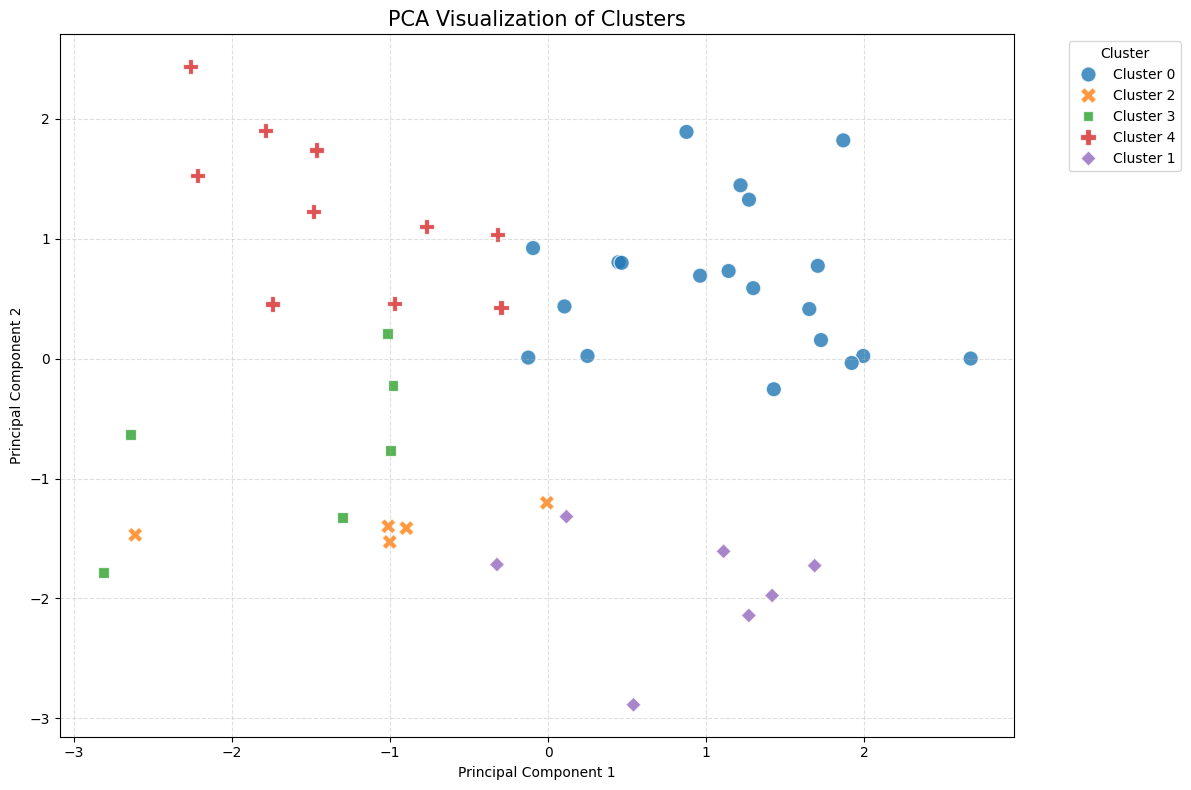

In [50]:
#PCA Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_pca,
    x='PCA1',
    y='PCA2',
    hue='Cluster_Label',
    style='Cluster_Label',
    s=120,
    alpha=0.8)

plt.title('PCA Visualization of Clusters', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

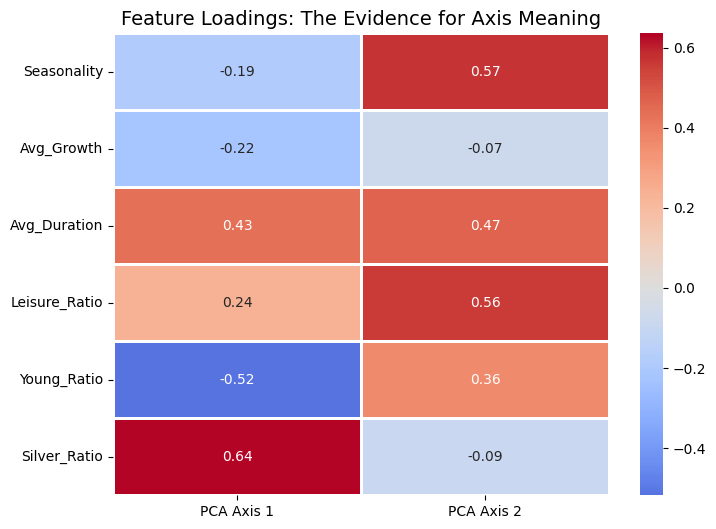

In [51]:
#Define Features (same columns used for clustering)
features = ['Seasonality', 'Avg_Growth', 'Avg_Duration', 'Leisure_Ratio', 'Young_Ratio', 'Silver_Ratio']

#Create Loadings Table
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PCA Axis 1', 'PCA Axis 2'],
    index=features)

#Visualise
plt.figure(figsize=(8, 6))
sns.heatmap(
    loadings,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    linewidths=1)

plt.title('Feature Loadings: The Evidence for Axis Meaning', fontsize=14)
plt.show()

### Feature Importance

In [52]:
df_clustered

,Seasonality,Avg_Growth,Avg_Duration,Leisure_Ratio,Young_Ratio,Silver_Ratio,Cluster
Country,,,,,,,
Australia,0.511784,0.101815,12.166667,0.939152,0.148661,0.204523,0
Austria,0.655939,0.113797,14.244444,0.911461,0.168811,0.189922,0
Bangladesh,0.333145,-0.003023,6.228571,0.895526,0.190027,0.065255,2
Belgium,0.555661,0.055244,12.055556,0.945742,0.208768,0.127862,0
Canada,0.385099,0.081523,14.588889,0.942934,0.124994,0.189846,0
China,0.689634,0.323392,8.628889,0.916311,0.213142,0.114579,3
Czech Republic,0.691379,0.163384,10.010926,0.972560,0.212235,0.113930,4
Denmark,0.774770,0.118984,14.388889,0.918188,0.198621,0.182529,0
Finland,1.017964,0.238371,13.200000,0.940380,0.176225,0.178733,0


In [53]:
#Features used in clustering
features = ['Seasonality', 'Avg_Growth', 'Avg_Duration', 'Leisure_Ratio', 'Young_Ratio', 'Silver_Ratio']

X = df_clustered[features]
y = df_clustered['Cluster']

#ANOVA F-statistic
f_scores, p_values = f_classif(X, y)

#Results table
cluster_importance = pd.DataFrame({
    'Feature': features,
    'F_Score': f_scores,
    'p_value': p_values}).sort_values('F_Score', ascending=False)

cluster_importance

,Feature,F_Score,p_value
2,Avg_Duration,27.685820,2.092133e-11
1,Avg_Growth,24.071761,1.682157e-10
5,Silver_Ratio,20.981500,1.189983e-09
3,Leisure_Ratio,19.887292,2.487235e-09
4,Young_Ratio,15.074507,8.882556e-08
0,Seasonality,9.202288,1.834454e-05


In [54]:
#Get cluster centers (scaled space)
centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=features)

#Measure variability across clusters
centroid_variance = centroids.var().sort_values(ascending=False)

centroid_variance

,0
Avg_Growth,1.356422
Leisure_Ratio,0.973676
Silver_Ratio,0.791345
Young_Ratio,0.790350
Seasonality,0.774464
Avg_Duration,0.663528


/tmp/ipython-input-997536755.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


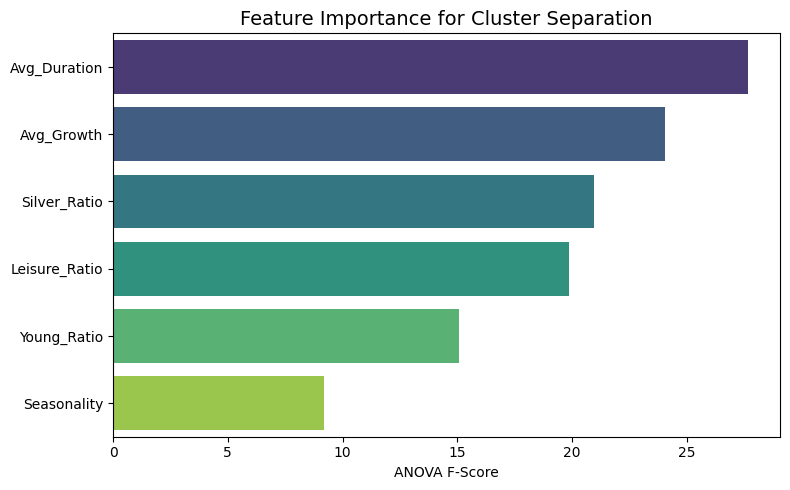

In [55]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=cluster_importance,
    x='F_Score',
    y='Feature',
    palette='viridis')

plt.title('Feature Importance for Cluster Separation', fontsize=14)
plt.xlabel('ANOVA F-Score')
plt.ylabel('')
plt.tight_layout()
plt.show()

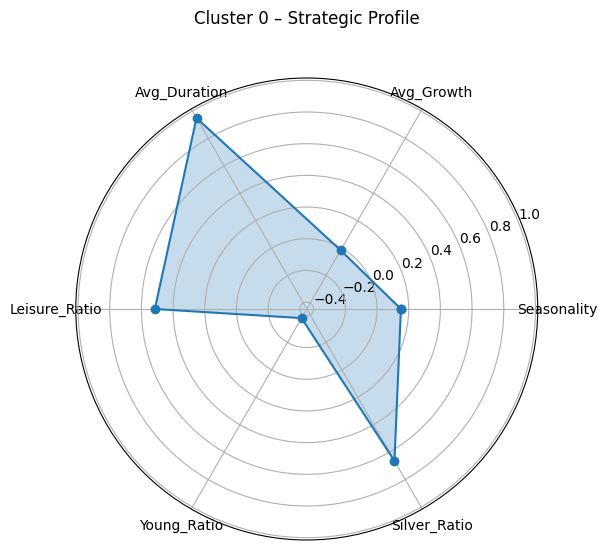

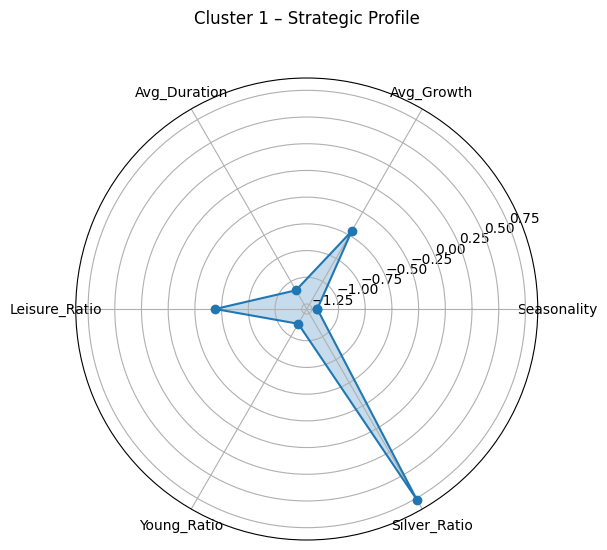

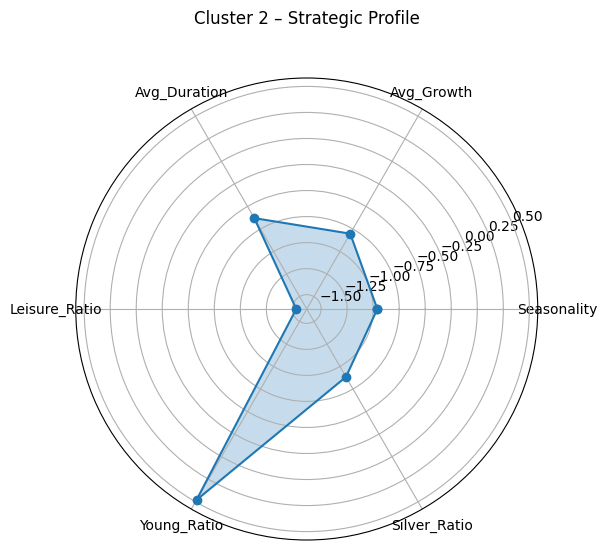

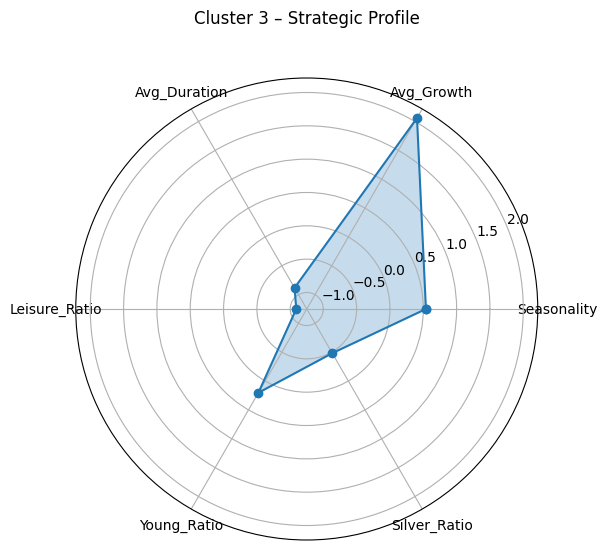

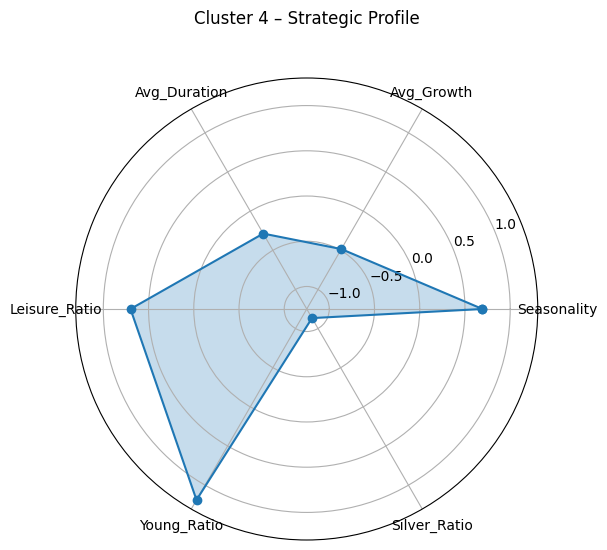

In [56]:
#Radar Chart/ Spider Plot

#Calculate mean feature values per cluster
cluster_profile = df_clustered.groupby('Cluster')[features].mean()

# Z-score normalization for visualization
cluster_profile_z = (cluster_profile - df_master[features].mean()) / df_master[features].std()

def plot_cluster_radar(cluster_id, data, features):
    values = data.loc[cluster_id].values
    values = np.append(values, values[0])  # close the circle

    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False)
    angles = np.append(angles, angles[0])

    plt.figure(figsize=(6, 6))
    plt.polar(angles, values, marker='o')
    plt.fill(angles, values, alpha=0.25)

    plt.xticks(angles[:-1], features)
    plt.title(f'Cluster {cluster_id} – Strategic Profile', y=1.1)
    plt.grid(True)
    plt.show()

for cluster_id in cluster_profile_z.index:
    plot_cluster_radar(cluster_id, cluster_profile_z, features)

### Focus Clusters

In [57]:
#Economic Size Calculation

#Total Arrivals per row (year-level)
df_arrivals['Total_Arrivals'] = df_arrivals[month_columns].sum(axis=1)

#Total arrivals per country
total_volume = df_arrivals.groupby('Country')['Total_Arrivals'].sum()

#Attach volume to clustered dataset
df_strategy = df_clustered.copy()
df_strategy['Total_Volume'] = df_strategy.index.map(total_volume)

#Economic Impact Proxy (Bed Nights)
df_strategy['Total Bed Nights'] = (df_strategy['Total_Volume'] * df_strategy['Avg_Duration'])

In [58]:
#STRATEGIC TACTIC ASSIGNMENT

cluster_strategy = {
    0: "Cluster 0",
    1: "Cluster 1",
    2: "Cluster 2",
    3: "Cluster 3",
    4: "Cluster 4"}

df_strategy['Strategic_Tactic'] = df_strategy['Cluster'].map(cluster_strategy)

In [59]:
df_strategy

,Seasonality,Avg_Growth,Avg_Duration,Leisure_Ratio,Young_Ratio,Silver_Ratio,Cluster,Total_Volume,Total Bed Nights,Strategic_Tactic
Country,,,,,,,,,,
Australia,0.511784,0.101815,12.166667,0.939152,0.148661,0.204523,0,628467,7.646348e+06,Cluster 0
Austria,0.655939,0.113797,14.244444,0.911461,0.168811,0.189922,0,120964,1.723065e+06,Cluster 0
Bangladesh,0.333145,-0.003023,6.228571,0.895526,0.190027,0.065255,2,74751,4.655919e+05,Cluster 2
Belgium,0.555661,0.055244,12.055556,0.945742,0.208768,0.127862,0,115022,1.386654e+06,Cluster 0
Canada,0.385099,0.081523,14.588889,0.942934,0.124994,0.189846,0,348368,5.082302e+06,Cluster 0
China,0.689634,0.323392,8.628889,0.916311,0.213142,0.114579,3,1457574,1.257724e+07,Cluster 3
Czech Republic,0.691379,0.163384,10.010926,0.972560,0.212235,0.113930,4,94533,9.463629e+05,Cluster 4
Denmark,0.774770,0.118984,14.388889,0.918188,0.198621,0.182529,0,124028,1.784625e+06,Cluster 0
Finland,1.017964,0.238371,13.200000,0.940380,0.176225,0.178733,0,24405,3.221460e+05,Cluster 0


In [60]:
#EXECUTIVE STRATEGY SUMMARY

exec_summary = (
    df_strategy
    .groupby('Cluster')
    .agg(
        Avg_Growth=('Avg_Growth', 'mean'),
        Total_Volume=('Total_Volume', 'sum'),
        Economic_Value=('Total Bed Nights', 'sum'),
        Strategy=('Strategic_Tactic', 'first'))
    .sort_values('Economic_Value', ascending=False))

#Market shares
exec_summary['Volume_Share'] = exec_summary['Total_Volume'] / exec_summary['Total_Volume'].sum()
exec_summary['Value_Share'] = exec_summary['Economic_Value'] / exec_summary['Economic_Value'].sum()

#Formatting
exec_summary['Avg_Growth'] = exec_summary['Avg_Growth'].map(lambda x: f"{x:.1%}")
exec_summary['Volume_Share'] = exec_summary['Volume_Share'].map(lambda x: f"{x:.1%}")
exec_summary['Value_Share'] = exec_summary['Value_Share'].map(lambda x: f"{x:.1%}")

In [61]:
exec_summary

,Avg_Growth,Total_Volume,Economic_Value,Strategy,Volume_Share,Value_Share
Cluster,,,,,,
0,12.7%,6563373,8.342894e+07,Cluster 0,44.1%,55.3%
1,6.2%,3573243,2.506226e+07,Cluster 1,24.0%,16.6%
4,5.9%,1911366,1.865997e+07,Cluster 4,12.8%,12.4%
3,42.9%,1862075,1.558712e+07,Cluster 3,12.5%,10.3%
2,1.2%,967709,8.037173e+06,Cluster 2,6.5%,5.3%


Visualisation

In [62]:
#Merge cluster labels into arrivals data
df_plot_cluster = df_arrivals_long.merge(
    df_clustered[['Cluster']],
    left_on='Country',
    right_index=True,
    how='inner')

In [63]:
df_plot_cluster

,Year,Region,Country,Month,Arrivals,Month_Num,Date,Quarter,MA_3,YoY_Growth,Cluster
34,2011,Australasia,Australia,1,3588,1,2011-01-01,1,NaN,NaN,0
425,2011,Australasia,Australia,2,2223,2,2011-02-01,1,NaN,NaN,0
816,2011,Australasia,Australia,3,3017,3,2011-03-01,1,2942.666667,NaN,0
1207,2011,Australasia,Australia,4,3341,4,2011-04-01,2,2860.333333,NaN,0
1598,2011,Australasia,Australia,5,1764,5,2011-05-01,2,2707.333333,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
3099,2019,Eastern Europe,Ukraine,8,985,8,2019-08-01,3,782.666667,-0.348976,4
3490,2019,Eastern Europe,Ukraine,9,1321,9,2019-09-01,3,1024.666667,-0.423647,4
3881,2019,Eastern Europe,Ukraine,10,2655,10,2019-10-01,4,1653.666667,-0.011909,4
4272,2019,Eastern Europe,Ukraine,11,4770,11,2019-11-01,4,2915.333333,0.383010,4


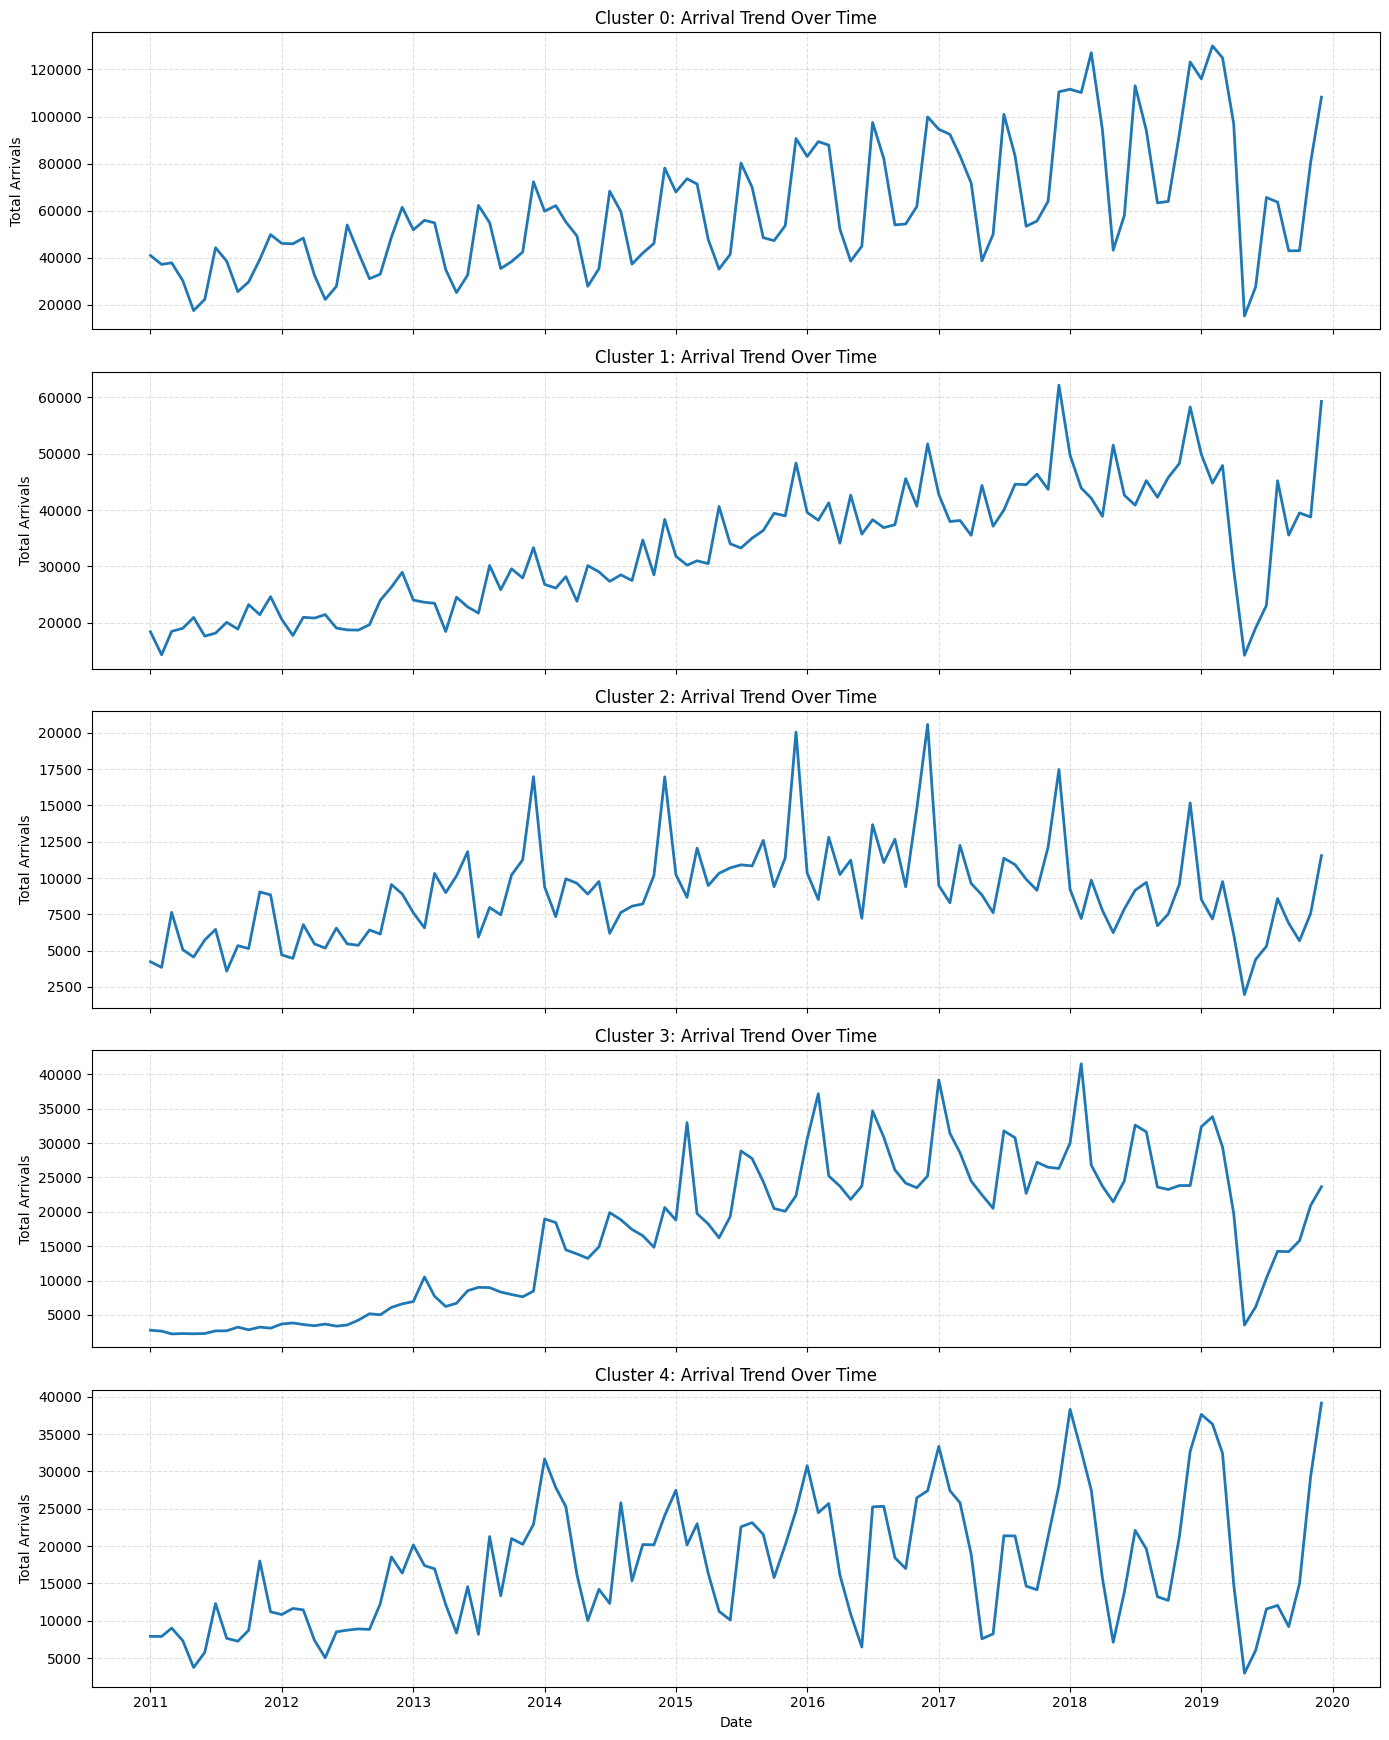

In [64]:
clusters = sorted(df_plot_cluster['Cluster'].unique())

fig, axes = plt.subplots(len(clusters), 1, figsize=(14, 3.5 * len(clusters)), sharex=True)

for i, cluster_id in enumerate(clusters):
    ax = axes[i]

    data = df_plot_cluster[df_plot_cluster['Cluster'] == cluster_id]
    trend = data.groupby('Date')['Arrivals'].sum().reset_index()

    ax.plot(trend['Date'], trend['Arrivals'], linewidth=2)
    ax.set_title(f'Cluster {cluster_id}: Arrival Trend Over Time', fontsize=12)
    ax.set_ylabel('Total Arrivals')
    ax.grid(True, linestyle='--', alpha=0.4)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


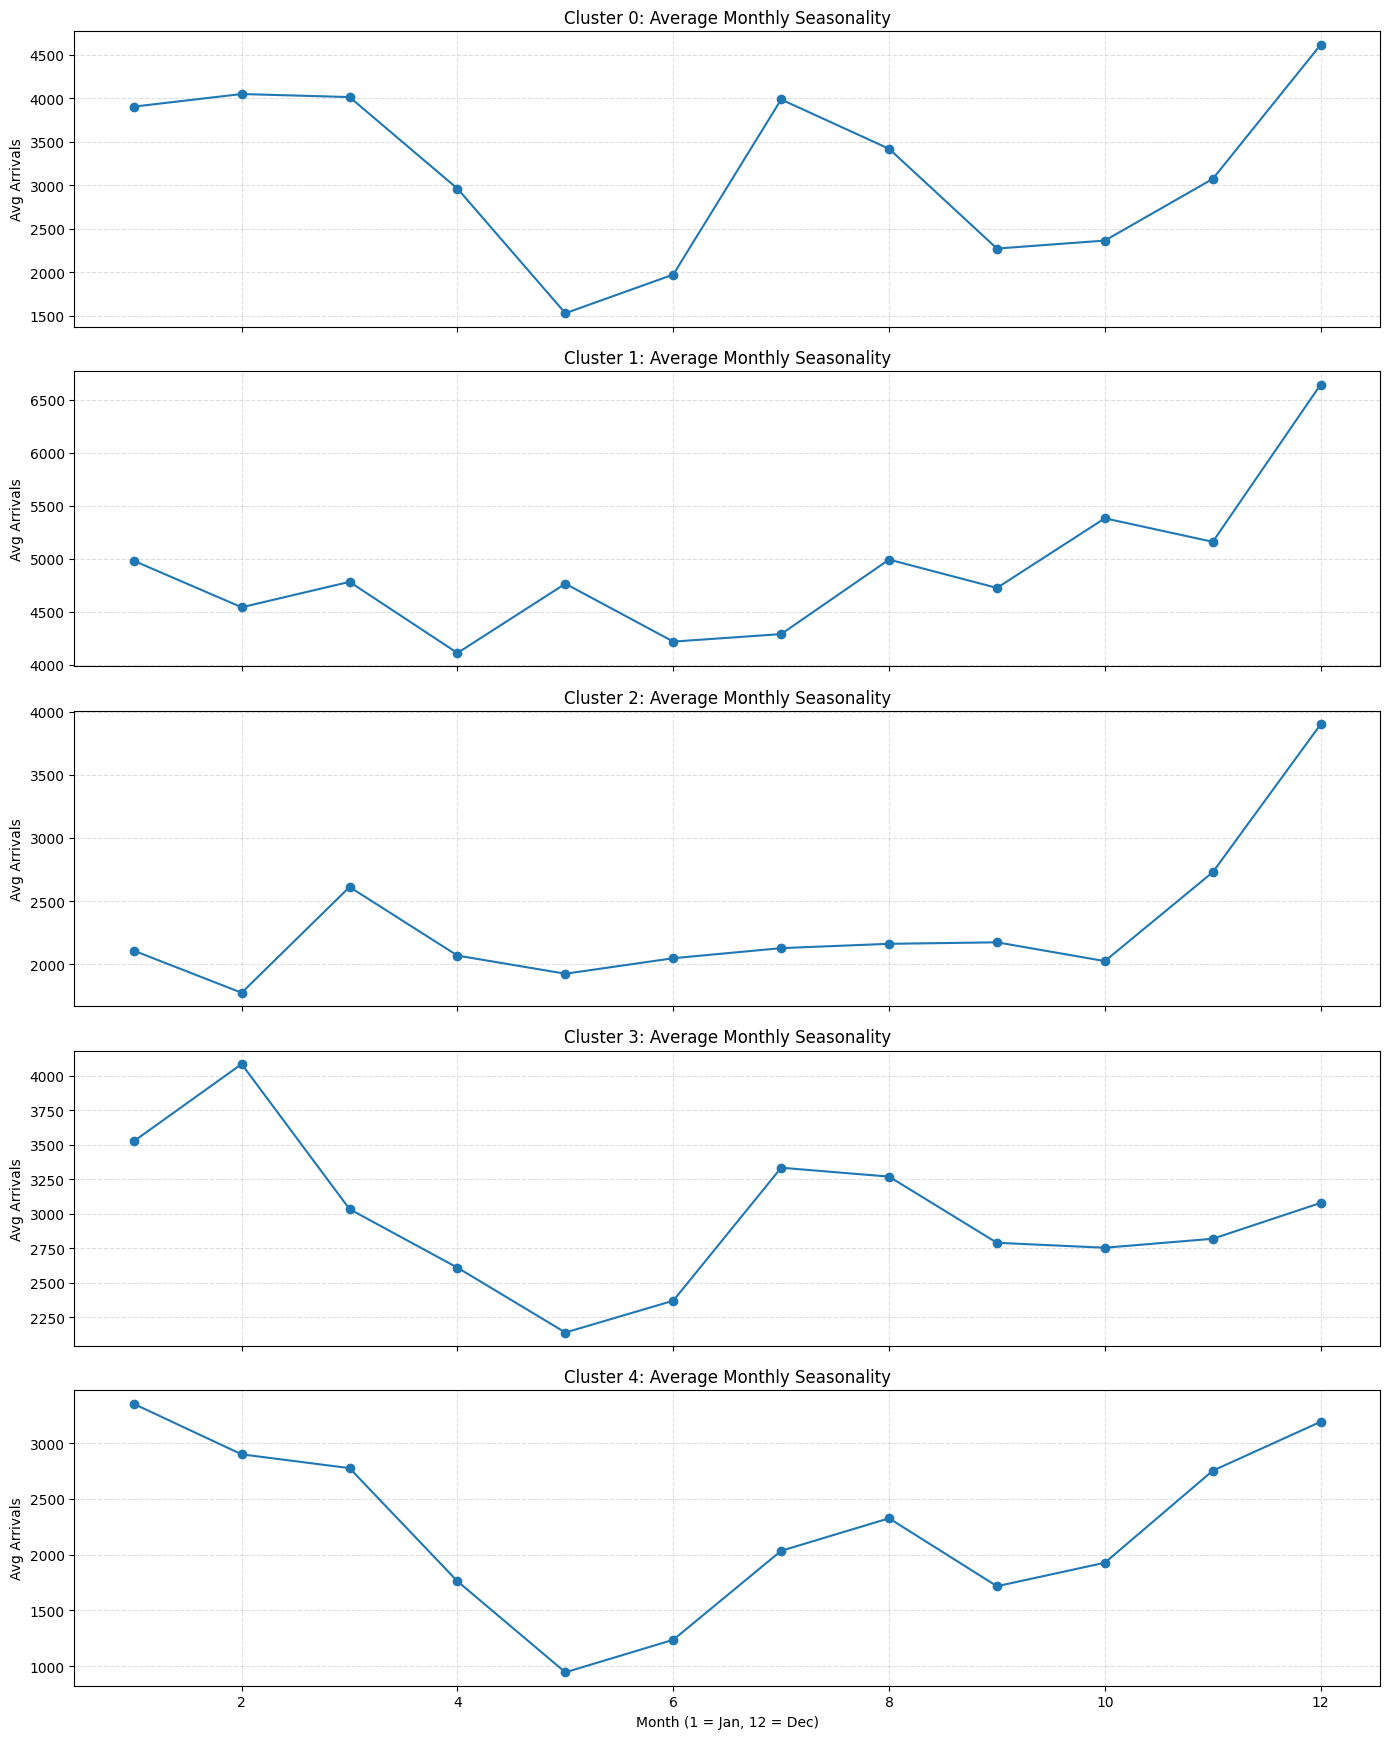

In [65]:
fig, axes = plt.subplots(len(clusters), 1, figsize=(14, 3.5 * len(clusters)), sharex=True)

for i, cluster_id in enumerate(clusters):
    ax = axes[i]

    data = df_plot_cluster[df_plot_cluster['Cluster'] == cluster_id]

    # Average arrivals per month (seasonality)
    seasonality = data.groupby('Month_Num')['Arrivals'].mean().reset_index()

    ax.plot(seasonality['Month_Num'], seasonality['Arrivals'], marker='o')
    ax.set_title(f'Cluster {cluster_id}: Average Monthly Seasonality', fontsize=12)
    ax.set_ylabel('Avg Arrivals')
    ax.grid(True, linestyle='--', alpha=0.4)

axes[-1].set_xlabel('Month (1 = Jan, 12 = Dec)')
plt.tight_layout()
plt.show()

In [66]:
def plot_cluster_arrivals(cluster_id, aggregate=True):
    # Filter selected cluster
    data = df_plot_cluster[df_plot_cluster['Cluster'] == cluster_id]

    plt.figure(figsize=(14, 6))

    if aggregate:
        # Aggregate total arrivals per month
        trend = data.groupby('Date')['Arrivals'].sum().reset_index()
        plt.plot(trend['Date'], trend['Arrivals'], linewidth=2.5)
        plt.ylabel('Total Arrivals')
    else:
        # Plot each country separately
        sns.lineplot(
            data=data,
            x='Date',
            y='Arrivals',
            hue='Country',
            legend=False)
        plt.ylabel('Arrivals')

    plt.title(f'Tourism Arrivals Over Time — Cluster {cluster_id}', fontsize=15)
    plt.xlabel('Date')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

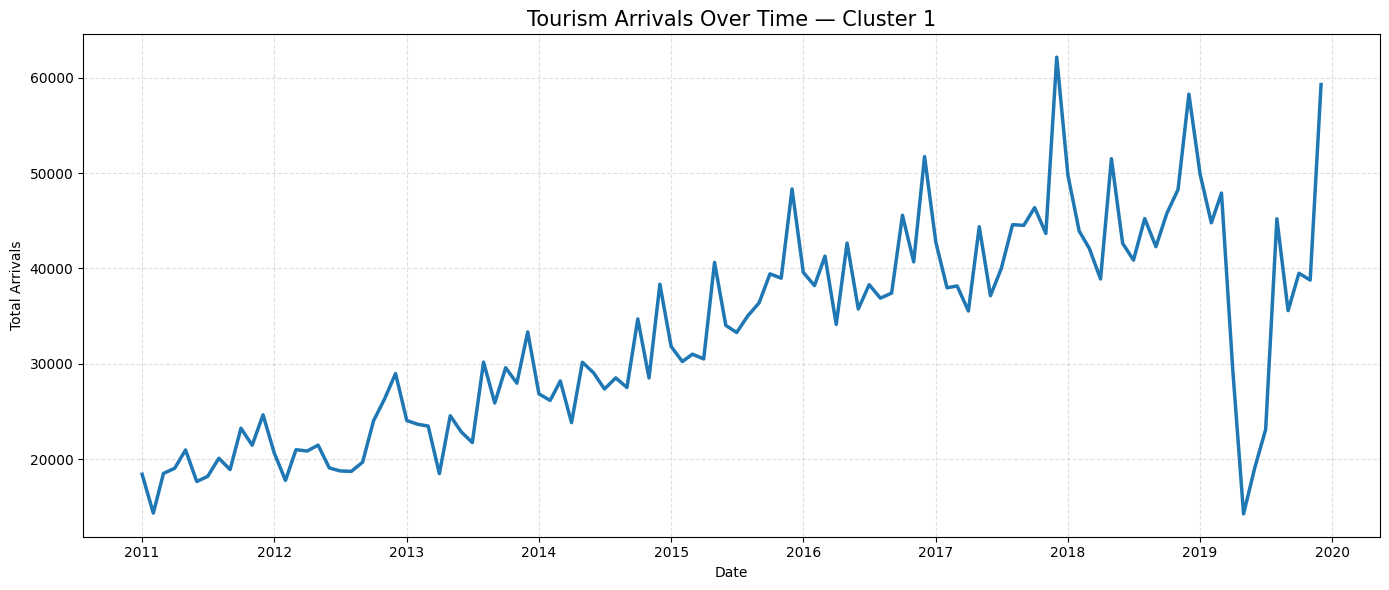

In [67]:
plot_cluster_arrivals(1)